# Fourier De-Dopper Techniques

In [4]:
# Perform some preliminary Julia setup
# This may take some time the very first time it runs
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Plots
using FFTW
using HDF5
default(legend=false)

  Activating project at `~/JuliaDeDopplerNotebooks`


## Load data and plot spectrogram

We will use the same small patch of the Voyager 1 data that we used in the
previous notebook which provided more background on the data and how to access
it.  We will just dive right into the data in this notebook.

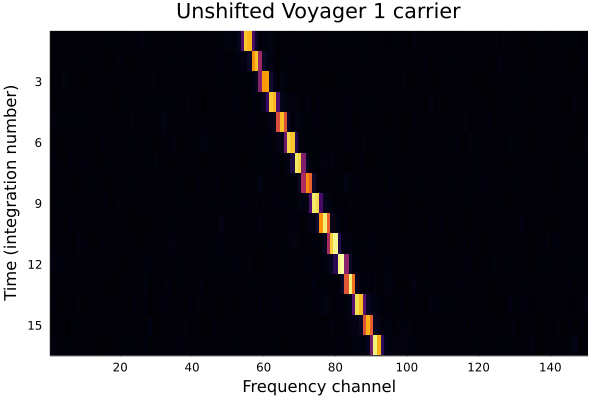

In [5]:
voyager_url = "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"
h5 = h5open(download(voyager_url))

freq_range = range(659935, length=150)
spectrogram = h5["data"][freq_range,1,:]

heatmap(spectrogram',
    title="Unshifted Voyager 1 carrier",
    xlabel="Frequency channel",
    ylabel="Time (integration number)",
    yflip=true
)

## Shifting data in the Fourier domain

As shown in the first notebook, we will shift the data by multiplying in the
Fourier domain by a phasor.  We will use a similar technique here, but with a
few changes to make this more efficient for generating the frequency drift rate
matrix.

Recall that the phasor function from the first notebook took a one dimensional
location $k$, an absolute shift amount $s$, and an overall length value $N$.
This allows us to shift a given spectrum by a specific amount, however we really
want to shift multiple spectra by linearly increasing amounts (i.e. a drift
rate).

The phasor function we define here will take a two dimensional location given by
parameters $k$ and $n$, a drift rate parameter $r$, and an overall length value
$N$.  The shift amount will be computed as $n \cdot r$.  Defining the phasor
function this way will allow us to operate on the matrix level rather than
looping over columns or rows.

To make this amenable with Julia's broadcast functionality, we also define a
method of `phasor` that accepts a `CartesianIndex` rather than individual $k$
and $n$ values.  Notice how this method uses the original method, but subtracts
1 from the $k$ and $n$ components of the `CartesianIndex` due to Julia's 1-based
indexing.  Don't worry if this seems confusing at first.  It will all make sense
later on.

In [6]:
function phasor(k,n,r,N)
    exp(-2im*π*k*n*r/N)
end

function phasor(i::CartesianIndex, r, N)
    phasor(i[1]-1, i[2]-1, r, N)
end

phasor (generic function with 2 methods)

We will also tweak the `fdshift` function from the first notebook to operate on
an entire spectrogram rather than a vector.  Another tweak we will incorporate
is to the sum along the time dimension in to the modified `fdshift` function.
This is not just a mere convenience.  Thanks to the linearity of the DFT, we can
perform the summation in the Fourier domain and then perform just a single
inverse FFT rather than $Nt$ inverse FFTs and then summing.  Speaking of the
inverse FFT, we will actually use the *backwards FFT*, which is like the inverse
FFT, but omits the final scaling step that is not necessary for our purposes.

Thw final tweak we will make is to accept a caller supplied destination for the
output vector.  To be even more flexible, we could allow for a caller supplied
`Matrix{Complex}` to hold the output of the `rfft` and a caller supplied
`Vector{Complex}` to hold the complex sum in the Fourier domain, but that's
beyond the scope of this notebook.  Because we modify the user supplied
destination vector this is a *mutating function* (because it mutates an input
parameter), so we will follow the Julia convention for mutating functions and
add a `!` to the end of the function name.

Notice that this function takes a `rate` parameter rather than an absolute shift
amount.  The `rate` parameter is assumed to be normalized (i.e. in units of
samples rather than $\mathrm{Hz}/\mathrm{s}$).

In [24]:
function fdshift!(dest::AbstractVector{<:Real}, spectrogram::AbstractMatrix{<:Real}, rate)
    Nf = size(spectrogram, 1)
    @assert length(dest) == Nf "Incorrect destination size"

    # Calculate real FFT of spectrogram to get into the Fourier domain
    fd = rfft(spectrogram, 1)

    # Multiply the fourier domain spectra by the dopper rate phasors.  Notice
    # how we broadcast the `phasor`` call over the `CatersianIndices` of `fd` as
    # well as broadcast the `*=`` multiply-assignment operator.  This allows
    # Julia to fuse these operations so we avoid having to allocate and store
    # intermediate results. 
    fd .*= phasor.(CartesianIndices(fd), rate, Nf)

    # Sum over time in the Fourier domain
    fdsum = sum(fd, dims=2)

    # Store the backwards real FFT of `fdsum` into `dest`.
    # Annoyingly, there is not `bffrt!` function in Julia's `AbstractFFTs` or
    # `FFTW` package so we have to use `brfft`, which allocates, and then use
    # broadcast assignment to store the output into `dest`.
    #brfft!(dest, fdsum)
    dest .= brfft(fdsum, Nf)
end


fdshift! (generic function with 1 method)

Now we can create a function named `fftfdr` that creates a frequency drift rate
matrix for a given spectrogram and range of rates using the `fdshift!` function.
This looping over drift rates is still a bit of a brute-force approach, but we
will address that in a future notebook.  Notice how we use Julia's `@view` macro
so that indexing `fdr` returns a view (aka `SubArray`) into `fdr` rather than a
copy of the data.  This allows `fdshift!` to store the results directly into the
columns of `fdr`.

In [14]:
function fftfdr(spectrogram, rates)
    Nf = size(spectrogram, 1)
    Nr = length(rates)
    fdr = similar(spectrogram, Nf, Nr)
    for (i,r) in enumerate(rates)
        fdshift!(@view(fdr[:,i]), spectrogram, r)
    end
    return fdr
end

fftfdr (generic function with 1 method)

Let's try it out for drift rates from 0 to -5, stepping by -0.25 each time. 

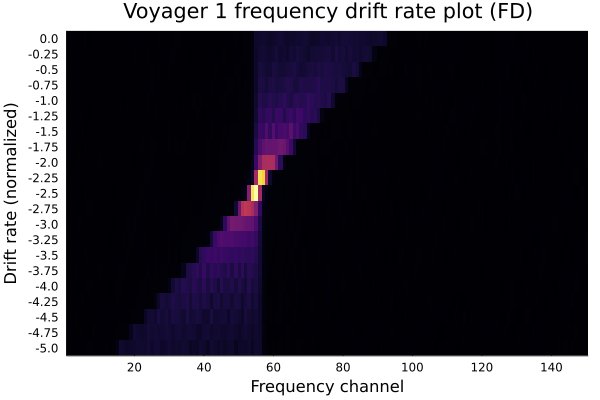

In [28]:
rates = 0:-0.25:-5
Nr = length(rates)
fdr = fftfdr(spectrogram, rates)
heatmap(fdr',
    title = "Voyager 1 frequency drift rate plot (FD)",
    xlabel = "Frequency channel",
    ylabel = "Drift rate (normalized)",
    yflip=true, yticks=(1:Nr, rates)
)

This looks quite similar to the butterfly plot of the previous notebook.  Let's take a look at the same zoomed in region that we examine in that notebook.

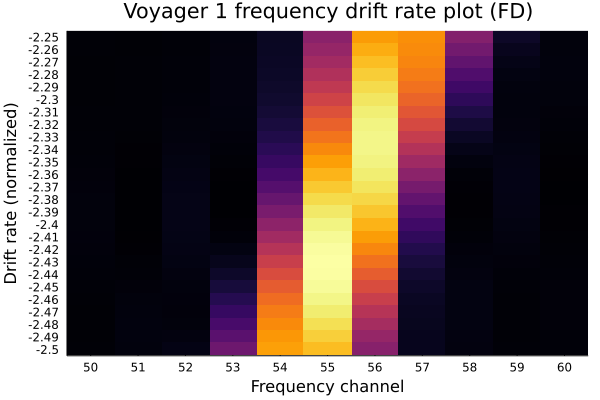

In [29]:
rates_zoom = -2.25:-0.01:-2.5
Nrz = length(rates_zoom)
fdr_zoom = fftfdr(spectrogram, rates_zoom)
heatmap(50:60, 1:Nrz, fdr_zoom[50:60, :]',
    title="Voyager 1 frequency drift rate plot (FD)",
    xlabel="Frequency channel",
    ylabel="Drift rate (normalized)",
    xticks=50:60,
    yticks=(1:Nrz, rates_zoom),
    yflip=true
)

We still have a two comparable peaks in adjacent channels, but the rise and fall
of the data in each channel is far smoother than in the previous notebook.  This
can be seen by plotting channels 55 and 56 over drift rate.

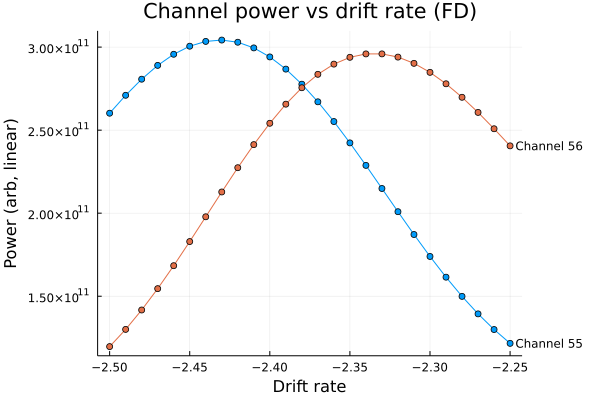

In [30]:
plot(rates_zoom, fdr_zoom[55:56, :]',
    title = "Channel power vs drift rate (FD)",
    xlabel = "Drift rate",
    ylabel = "Power (arb, linear)",
    labels = ["Channel 55" "Channel 56"],
    legend = :inline,
    marker = true
)

Perhaps an additional offset of half a channel, independent of rate,  would
better align the signal with our frequency channels and consolidate the
frequency drift rate peaks into a single peak, but that's an exercise for a
future version of this notebook.

## Benchmarking

Let's benchmark the performance of our `fftfdr` function using Julia's benchmarking tools.

In [34]:
using BenchmarkTools
@benchmark fftfdr($spectrogram, $rates)

BenchmarkTools.Trial: 3126 samples with 1 evaluation.
 Range (min … max):  1.467 ms … 27.940 ms  ┊ GC (min … max): 0.00% … 31.18%
 Time  (median):     1.488 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.596 ms ±  1.620 ms  ┊ GC (mean ± σ):  1.97% ±  1.83%

      ▂▃▄█▆▅▆▃▆▂▂                                             
  ▂▃▄▇████████████▆▆▅▅▄▄▃▃▃▃▂▃▂▂▂▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂ ▄
  1.47 ms        Histogram: frequency by time        1.58 ms <

 Memory estimate: 361.23 KiB, allocs estimate: 1429.

Let's try with the full spectrogram.

In [35]:
full_spectrogram = h5["data"][:,1,:]
@benchmark fftfdr($full_spectrogram, $rates)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 11.288 s (0.48% GC) to evaluate,
 with a memory estimate of 1.72 GiB, over 1535 allocations.

Well, that's even worse.  Maybe this Fourier domain stuff isn't really
worthwhile?  I was going to save GPUs for a future notebook, but let's take a
sneak peek at how this might work on a GPU.

### GPU programming using CUDA.jl

We will use Julia's amazing `CUDA.jl` package.  `CUDA.jl` provides access to the
full CUDA API and allows us to write kernels in Julia that get automatically
compiled directly to GPU runnable PTX code by Julia's underlying LLVM compiler,
no `vncc` or `NVRTC` required.  That's very cool, but wait, there's more!

`CUDA.jl` also allows us to use Julia's high level Array programming that we've
already been using and apply these functions and operations to data that are
stored in `CuArray`s, which are like `Arrays`, but whose data reside on the GPU.
When a `CuArray` is passed to these functions, CUDA.jl automatically converts
the Array-like operations into highly efficient kernel calls.  This means we
can get the amazing parallelization that GPUs provide without having to
write a single line of CUDA code or even any additional Julia code other than
copying our data to and from `CuArray`s!

In [44]:
using CUDA
# Disable scalar indexing to prevent use of inefficient access patterns
CUDA.allowscalar(false)

# Create a `CuArray` and copy the full spectrogram to it
cu_full_spectrogram = CuArray(full_spectrogram)

# Run the benchmark.  Notice that we synchronize the GPU using `CUDA.@sync`, so
# we are timing the actual time required to complete the operation, not just the
# time it takes to launch it asynchronously.
@benchmark CUDA.@sync fftfdr($cu_full_spectrogram, $rates)

BenchmarkTools.Trial: 59 samples with 1 evaluation.
 Range (min … max):  83.639 ms … 98.857 ms  ┊ GC (min … max): 0.00% … 5.15%
 Time  (median):     83.845 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   85.526 ms ±  4.270 ms  ┊ GC (mean ± σ):  0.64% ± 1.55%

  █ ▅                                                          
  █▁█▅▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▅▁▁▁▁▁▁▅▅▅▁▁▁▅ ▁
  83.6 ms      Histogram: log(frequency) by time      98.6 ms <

 Memory estimate: 134.12 KiB, allocs estimate: 2828.

Wow, that was easy and the speed up was fantastic!  All hope is not lost!  Hooray!  We'll do more GPU benchmarking comparisons in a future notebook.

In [45]:
# Run this cell to reclaim GPU memory from CUDA.jl's memory pool.  It's a bit of
# a funny name, because it feels more like we are releasing memory rather than
# reclaiming it, but I suppose it's all a matter of perspective.
CUDA.reclaim()